In [1]:
#!pip install tensorflow==2.10.1

In [2]:
import os
import re
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio as imageio
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, UpSampling2D, AveragePooling2D, MaxPool2D, MaxPooling2D, Concatenate, LeakyReLU, concatenate, Dropout, ReLU, Activation, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
print(tf.__version__)
print(cv2.__version__)
print(np.__version__)

2.12.0
4.8.0
1.23.5


In [4]:
WIDTH, HEIGHT = 256, 256
BATCH_SIZE = 16
lr = 1e-04
epochs = 100
image_size = [256,256]

In [5]:
model_path = "/kaggle/working/deeplabv3_carlo.h5"
csv_path = "/kaggle/working/csvlogger.csv"

# Helping Function

In [6]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
#get data
def read_data(path):
    images = sorted(glob(os.path.join(path, "CameraRGB/*")))
    masks = sorted(glob(os.path.join(path, "CameraSeg/*")))
    
    return images, masks

In [8]:
def show_images_with_masks(image_dir, mask_dir):
    #image_files = sorted(os.listdir(image_dir))
    #mask_files = sorted(os.listdir(mask_dir))

    # Ensure equal number of images and masks
    num_files = min(len(image_dir), len(image_dir))

    # Display 5 images and masks
    num_display = min(num_files, 5)
    fig, axs = plt.subplots(num_display, 2, figsize=(10, 10))

    for i in range(num_display):

        image = cv2.imread(image_dir[i])
        mask = cv2.imread(mask_dir[i])[:,:,2]

        # Display image
        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')

        # Display mask
        axs[i, 1].imshow(mask)
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_filenames,
                 mask_filenames,
                 batch_size=BATCH_SIZE,
                 shuffle=True):

        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.filenames = list(zip(img_filenames, mask_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.img_filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for img_file, mask_file in batches:
            image = cv2.imread(img_file)
            image = cv2.resize(image, (WIDTH, HEIGHT))
            image = image / 255.
            
            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (WIDTH, HEIGHT))[:, :, 2]

            imgs.append(image)
            segs.append(mask)

        return np.array(imgs), np.array(segs)
    
    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size

In [10]:
#set color to image
def give_color_to_seg_img(seg, n_classes=13):
    seg_img = np.zeros( (seg.shape[0],seg.shape[1], 3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

# Data Preparation and preprocessing

In [11]:
path_1 = "/kaggle/input/lyft-udacity-challenge/dataA/dataA"
path_2 = "/kaggle/input/lyft-udacity-challenge/dataB/dataB"
path_3 = "/kaggle/input/lyft-udacity-challenge/dataC/dataC"
path_4 = "/kaggle/input/lyft-udacity-challenge/dataD/dataD"
path_5 = "/kaggle/input/lyft-udacity-challenge/dataE/dataE"

In [12]:
images_1, masks_1 = read_data(path_1)
images_2, masks_2 = read_data(path_2)
images_3, masks_3 = read_data(path_3)
images_4, masks_4 = read_data(path_4)
images_5, masks_5 = read_data(path_5)

In [13]:
images = images_1 + images_2 + images_3 + images_4
masks = masks_1 + masks_2 + masks_3 + masks_4

In [14]:
len(images), len(masks)

(4000, 4000)

In [15]:
train_gen = DataGenerator(images, masks)
test_gen = DataGenerator(images_5, masks_5)

In [16]:
#train data shape
for x, y in train_gen:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256))

In [17]:
#test data shape
for x, y in test_gen:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256))

(-0.5, 255.5, 255.5, -0.5)

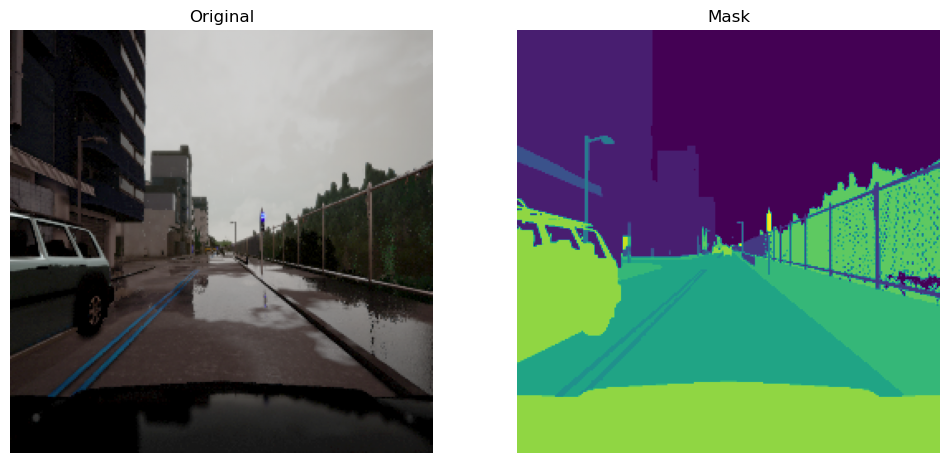

In [18]:
#visualize image and mask
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[0])
plt.title('Mask')
plt.axis('off')

# DeepLabV3+

![](https://www.researchgate.net/profile/Emad_Awwad/publication/339325687/figure/fig8/AS:859857078976514@1582017311235/Atrous-Spatial-Pyramid-Pooling-Module-ASPP.ppm)

In [19]:
def ASPP(inputs):
    shape = inputs.shape
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization()(y_pool)
    y_pool = Activation("relu")(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)
    
    y_1 = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation("relu")(y_1)
    
    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6 , padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation("relu")(y_6) 
    
    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12 , padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation("relu")(y_12) 
    
    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18 , padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation("relu")(y_18)  
    
    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    
    y = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(inputs)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    
    return y

In [20]:
def DeepLabV3Plus(shape):
    inputs = Input(shape)
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4,4), interpolation='bilinear')(x_a)
    
    #get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)
    
    x = Concatenate()([x_a, x_b])
    
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((4,4), interpolation='bilinear')(x)
    
    #output
    x = Conv2D(13, (1,1), name="output_layer")(x)
    x = Activation("sigmoid")(x)
    print(f'after : {x.shape}')
    
    #Model
    model = Model(inputs=inputs, outputs=x)
    return model

In [21]:
input_shape = (256, 256, 3)
model = DeepLabV3Plus(input_shape)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
after : (None, 256, 256, 13)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 


In [22]:
#learning rate
def lrfn(epoch):
    if epoch > 15:
        return 2e-4
    elif epoch > 25:
        return 1e-4
    return 1e-3

In [23]:
metrics = ['accuracy']
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=metrics)

In [24]:
#Callbacks
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step))
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    lr_callback
]

# Training

In [25]:
train_steps = len(train_gen)
val_steps = len(test_gen)

history = model.fit(train_gen, validation_data=test_gen, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 25, verbose=1, callbacks=Callbacks)

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.8774
Epoch 1: val_loss improved from inf to 4.61346, saving model to /kaggle/working/deeplabv3_carlo.h5
250/250 [==============================] - 227s 731ms/step - loss: 0.4304 - accuracy: 0.8774 - val_loss: 4.6135 - val_accuracy: 0.3011 - lr: 0.0010
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9298
Epoch 2: val_loss improved from 4.61346 to 1.81418, saving model to /kaggle/working/deeplabv3_carlo.h5
250/250 [==============================] - 125s 499ms/step - loss: 0.2449 - accuracy: 0.9298 - val_loss: 1.8142 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9391
Epoch 3: val_loss improved from 1.81418 to 0.61453, saving model to /kaggle/working/deeplabv3_carlo.h5
250/250 [==============================] - 126s 503ms/step - loss: 0.2119 - accuracy: 0.9391 - val_loss: 0.6145

# Model's Performance visualization

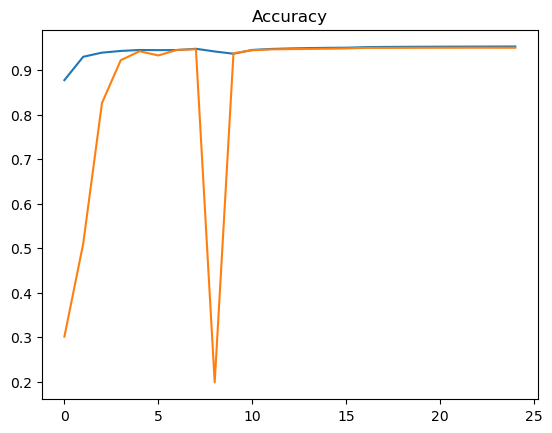

In [26]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.show()

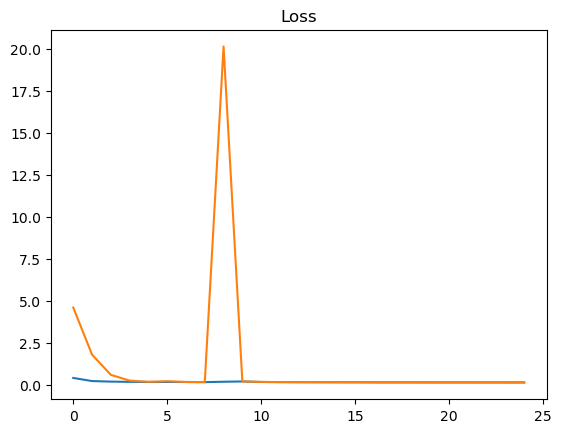

In [27]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.show()

# Prediction and Visualization

In [28]:
create_dir("/kaggle/working/predicted")

1/1 [==============================] - 1s 882ms/step


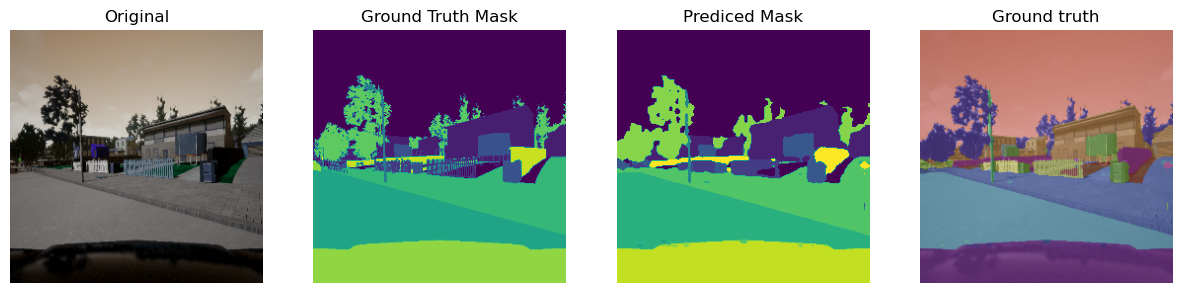

1/1 [==============================] - 0s 29ms/step


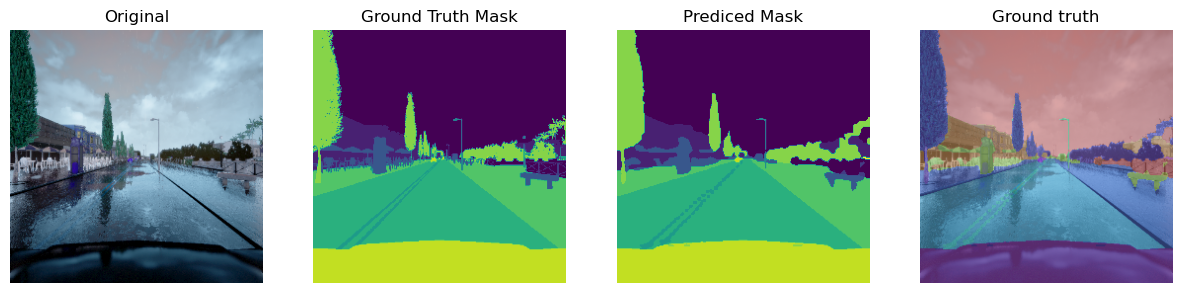

1/1 [==============================] - 0s 29ms/step


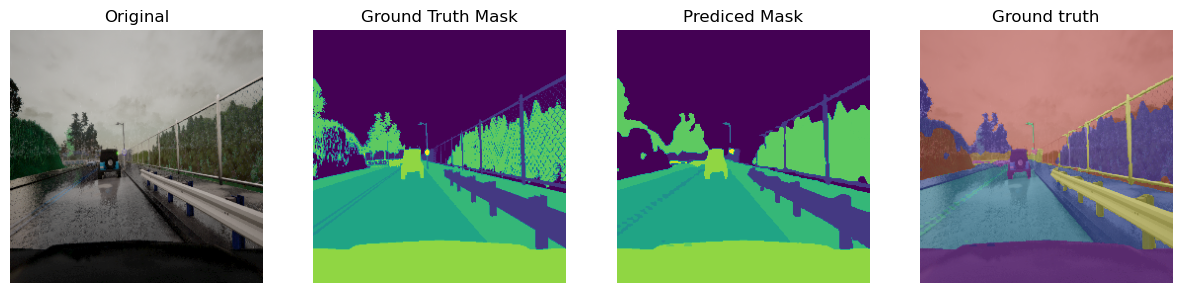

1/1 [==============================] - 0s 28ms/step


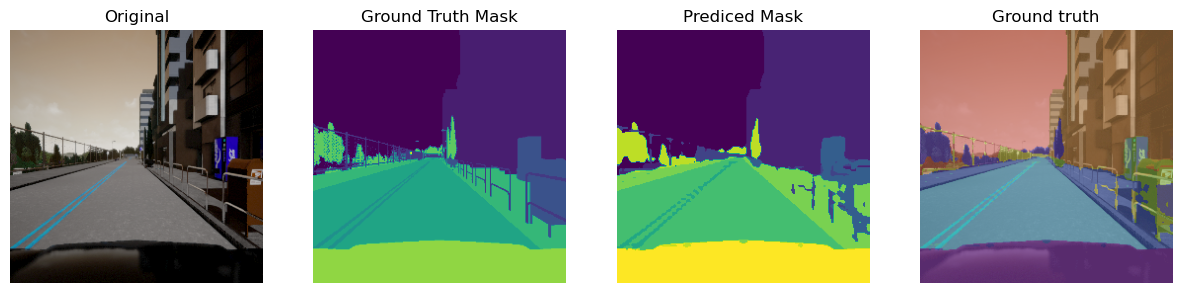

1/1 [==============================] - 0s 31ms/step


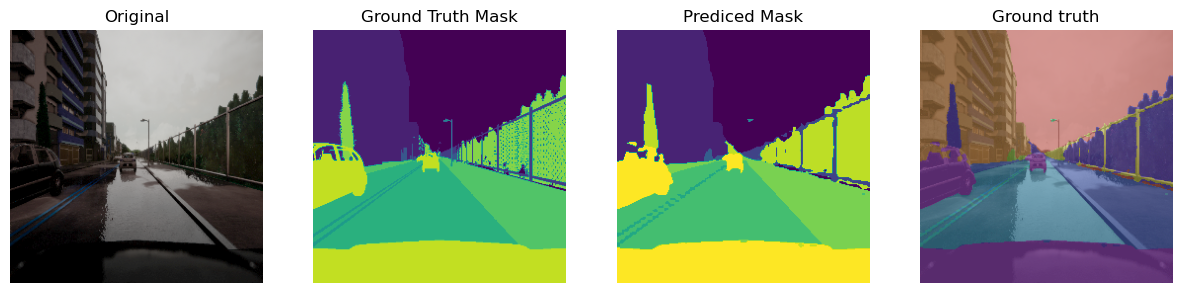

1/1 [==============================] - 0s 30ms/step


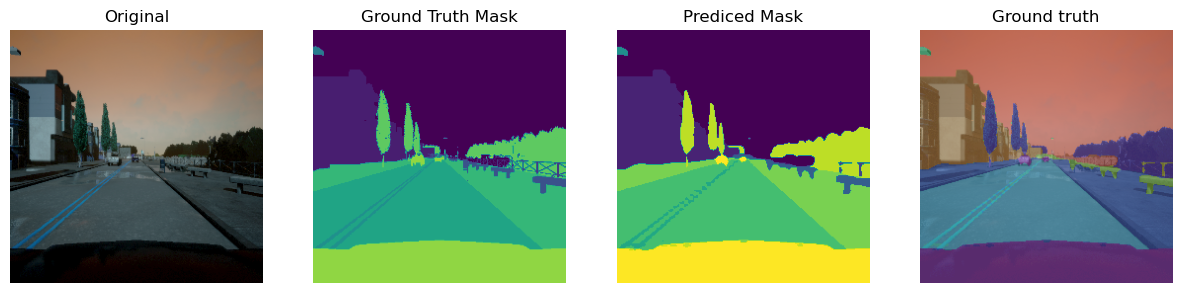

1/1 [==============================] - 0s 29ms/step


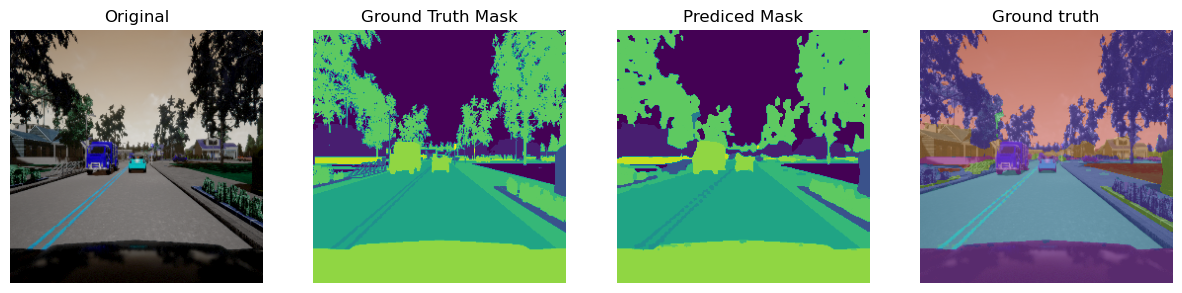

1/1 [==============================] - 0s 28ms/step


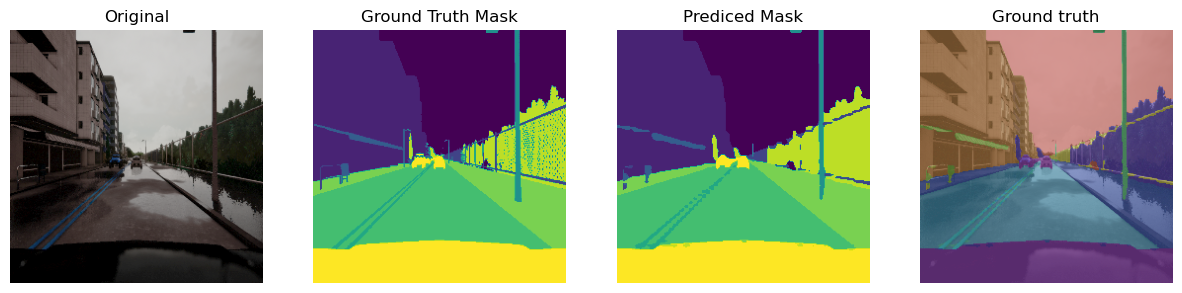

1/1 [==============================] - 0s 29ms/step


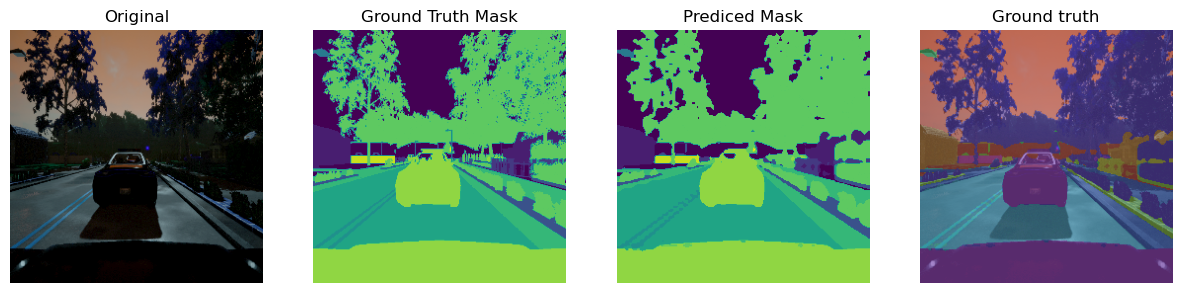

1/1 [==============================] - 0s 29ms/step


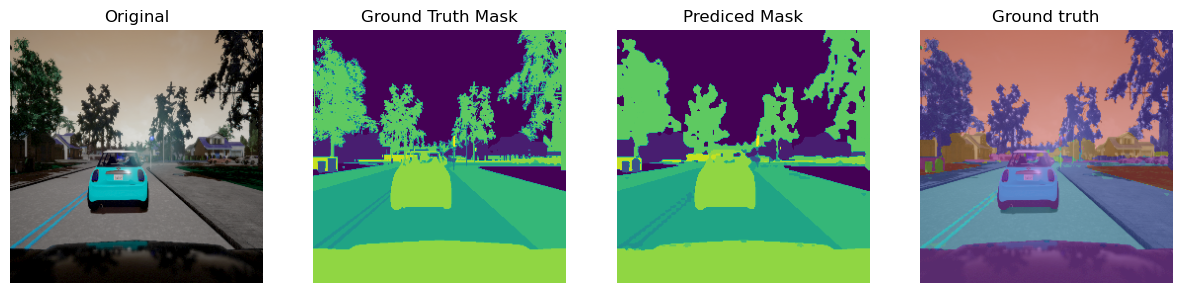

1/1 [==============================] - 0s 28ms/step


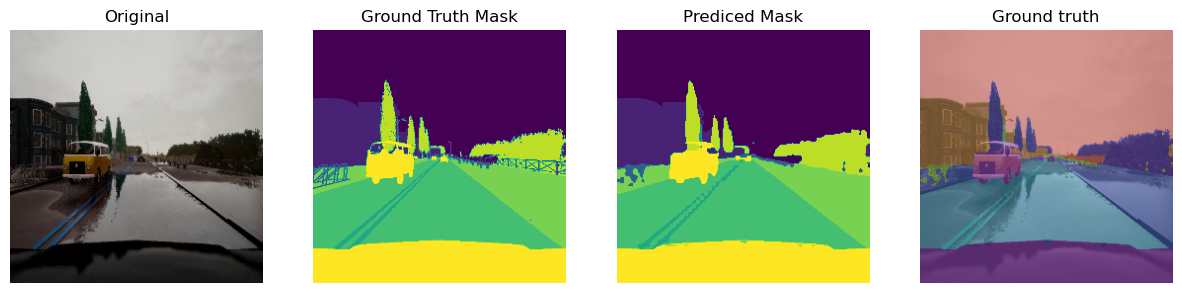

1/1 [==============================] - 0s 28ms/step


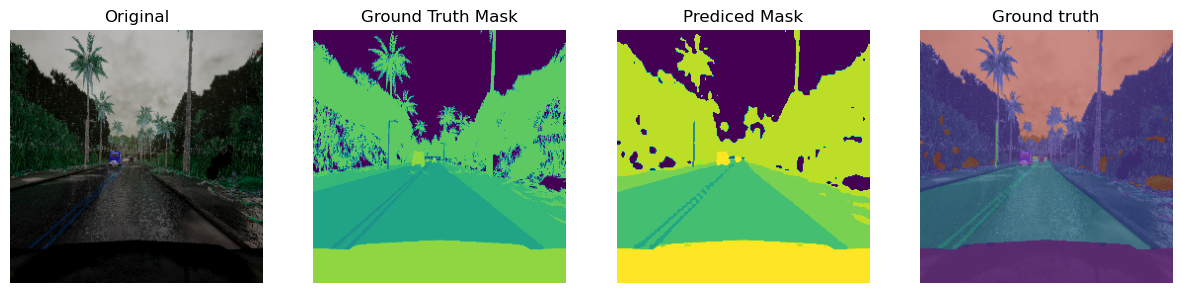

In [29]:
#prediction
max_show = 12
test_iter = iter(test_gen)
for i in range(max_show):
    images, masks = next(test_iter)
    mask_color = give_color_to_seg_img(masks[0])

    preds = model.predict(images)
    pred_masks = np.argmax(preds, axis = 3)
    pred_mask_color = give_color_to_seg_img(pred_masks[0])
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))
    
    for a in ax:
        a.axis('off')

    ax[0].imshow(images[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(masks[0])
    ax[1].set_title('Ground Truth Mask')
    
    ax[2].imshow(pred_masks[0])
    ax[2].set_title('Prediced Mask')
    
    ax[3].imshow(images[0] * 0.5 + pred_mask_color * 0.5)
    ax[3].set_title('Ground truth')
    plt.savefig(f"predicted/pred_{i}.jpg", dpi=150)
    plt.show()

# Model Evaluation

In [30]:
def iou_score(dataset):
    
    # Create empty lists 
    intersections, unions, max_ious, min_ious = [], [], [], []
    
    for images, masks in dataset:
        pred_mask = model.predict(images)
        pred_mask = pred_mask[:,:,:,1]
        
        #calculates the element-wise logical AND operation between the masks and pred_mask arrays
        intersection = np.logical_and(masks, pred_mask)
        
        #calculates the element-wise logical OR operation between the masks and pred_mask arrays
        union = np.logical_or(masks, pred_mask)
        
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])
        batch_iou_score = intersection_sum / union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)
        
        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)

    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections) / np.sum(unions)   
    
    return min_iou, max_iou, mean_iou

In [31]:
test_min_iou, test_max_iou, test_mean_iou = iou_score(test_gen)

1/1 [==============================] - 0s 29ms/step


In [32]:
print(f'IoU on the Test Dataset: \n Minimum IoU Score: {round(test_min_iou*100, 2)}% \n Maximum IoU Score: {round(test_max_iou*100, 2)}% \n Mean IoU Score: {round(test_mean_iou*100, 2)}% \n')

IoU on the Test Dataset: 
 Minimum IoU Score: 52.71% 
 Maximum IoU Score: 86.63% 
 Mean IoU Score: 69.67% 



# Convert Photos into Video

In [33]:
imagesB, masksB = read_data("/kaggle/input/lyft-udacity-challenge/dataB/dataB/")

In [34]:
output_file = "/kaggle/working/output_video.mp4"

# Open the first image to get its dimensions
first_image = cv2.imread(imagesB[0])
height, width, channels = first_image.shape

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Choose the desired video codec
video_writer = cv2.VideoWriter(output_file, fourcc, 24.0, (width, height))

# Iterate over the images and write them to the video
for image_name in imagesB:
    image = cv2.imread(image_name)
    video_writer.write(image)
    
# Release the VideoWriter and close the video file
video_writer.release()

print("Video conversion completed!")

Video conversion completed!
